In [1]:
import sys
sys.path.append("/Users/kang828/Documents/GitHub/arl-eegmodels")

import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet


In [34]:
WIDTH = 600

def produce_dataset(en_file, ow_file, SAMPLES=1000, WIDTH=600, interval=(0, 60000)):
    jack_eng = pd.read_pickle(en_file)
    jack_man = pd.read_pickle(ow_file)

    eng_samples = np.zeros((SAMPLES, 4, WIDTH))
    eng_labels = np.zeros((SAMPLES))
    man_samples = np.zeros((SAMPLES, 4, WIDTH))
    man_labels = np.ones((SAMPLES))

    eeg_eng = jack_eng[[1, 2, 3, 4]]
    eeg_man = jack_man[[1, 2, 3, 4]]

    if (interval[1] > len(jack_eng)):
        print("Potential Sampling Error")
    
    for idx in range(SAMPLES):
        start_time = np.random.randint(interval[0], min(interval[1], len(jack_eng)) - WIDTH)

        eng_samples[idx] = eeg_eng[start_time:start_time + WIDTH].T
        man_samples[idx] = eeg_man[start_time:start_time + WIDTH].T

    ## english is zero
    samples = np.vstack((eng_samples, man_samples))
    labels = np.append(eng_labels, man_labels)

    permutation = np.random.permutation(len(samples))
    samples = samples[permutation]
    labels = labels[permutation]

    labels = tf.one_hot(labels, 2)
    return samples, labels

In [9]:
samples, labels = produce_dataset("Jack_English", "Jack_Mandarin")
rena_samples, rena_labels = produce_dataset("Rene_Eng", "Rena_Korean")

In [10]:
# WIDTH = 600
# VALIDATION = 100
# eng_val = np.zeros((VALIDATION, 4, WIDTH))
# eng_labels_v = np.zeros((VALIDATION))

# man_val = np.zeros((VALIDATION, 4, WIDTH))
# man_labels_v = np.ones((VALIDATION))

# for idx in range(VALIDATION):    
#     start_time = np.random.randint(60000, len(eeg_eng) - WIDTH)

#     eng_val[idx] = eeg_eng[start_time:start_time + WIDTH].T
#     man_val[idx] = eeg_man[start_time:start_time + WIDTH].T

# ## english is zero
# vals = np.vstack((eng_val, man_val))
# labels_v = np.append(eng_labels_v, man_labels_v)

# permutation = np.random.permutation(len(vals))
# vals = vals[permutation]
# labels_v = labels_v[permutation]

# labels_v = tf.one_hot(labels_v, 2)

vals, labels_v = produce_dataset("Jack_English", "Jack_Mandarin", interval=(60000, 75562))

In [11]:
# model  = ShallowConvNet(nb_classes = 2, Chans = 4, Samples = WIDTH)
model = EEGNet(nb_classes = 2, Chans = 4, Samples = WIDTH)

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fittedModel = model.fit(x=samples, y=labels, validation_data=(vals, labels_v), epochs=2)

Epoch 1/2
63/63 [==============================] - 4s 50ms/step - loss: 0.5469 - accuracy: 0.7235 - val_loss: 0.4566 - val_accuracy: 0.8675
Epoch 2/2
63/63 [==============================] - 3s 47ms/step - loss: 0.3525 - accuracy: 0.8665 - val_loss: 0.2737 - val_accuracy: 0.9125


In [12]:
tf.math.confusion_matrix(tf.argmax(rena_labels, axis=1), tf.argmax(model.predict(rena_samples), axis=1))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[756, 244],
       [241, 759]], dtype=int32)>

In [13]:
# model.evaluate(rena_samples, rena_labels)
tf.math.confusion_matrix(tf.argmax(labels_v, axis=1), tf.argmax(model.predict(vals), axis=1))


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[893, 107],
       [ 68, 932]], dtype=int32)>

In [14]:
rena_samples, rena_labels = produce_dataset("Rene_Eng", "Rena_Korean", interval=(0, 76776))

In [16]:
jack_full_samples, jack_full_labels = produce_dataset("Jack_English", "Jack_Mandarin", interval=(0, 76552))

In [17]:
# model  = ShallowConvNet(nb_classes = 2, Chans = 4, Samples = WIDTH)
model_rev = EEGNet(nb_classes = 2, Chans = 4, Samples = WIDTH)

model_rev.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fittedModel_rev = model_rev.fit(x=rena_samples, y=rena_labels, validation_data=(jack_full_samples, jack_full_labels), epochs=2)

Epoch 1/2
63/63 [==============================] - 4s 47ms/step - loss: 0.5189 - accuracy: 0.7335 - val_loss: 0.6074 - val_accuracy: 0.6800
Epoch 2/2
63/63 [==============================] - 3s 43ms/step - loss: 0.3745 - accuracy: 0.8375 - val_loss: 0.6503 - val_accuracy: 0.7335


In [18]:
rena_samples_2, rena_labels_2 = produce_dataset("Rena_Eng_2", "Rena_Korean_2", interval=(0, 30695), SAMPLES=2000)
model_rev.evaluate(rena_samples_2, rena_labels_2)



125/125 [==============================] - 1s 8ms/step - loss: 0.3991 - accuracy: 0.7763


[0.3990939259529114, 0.7762500047683716]

In [19]:
model_rev_2 = EEGNet(nb_classes = 2, Chans = 4, Samples = WIDTH)

model_rev_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fittedModel_rev_2 = model_rev_2.fit(x=jack_full_samples, y=jack_full_labels, validation_data=(rena_samples, rena_labels), epochs=2)

Epoch 1/2
63/63 [==============================] - 4s 47ms/step - loss: 0.5124 - accuracy: 0.7630 - val_loss: 0.5464 - val_accuracy: 0.7500
Epoch 2/2
63/63 [==============================] - 3s 42ms/step - loss: 0.3092 - accuracy: 0.8775 - val_loss: 0.5503 - val_accuracy: 0.7030


In [30]:
j2_samples, j2_labels = produce_dataset("Jack_English_2", "Jack_Mandarin_2", interval=(0, 30695))
j3_samples, j3_labels = produce_dataset("Jack_English_3", "Jack_Mandarin_3", interval=(0, 30695))

model_rev_2.evaluate(j3_samples, j3_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.7500 - accuracy: 0.5240


[0.7499601244926453, 0.5239999890327454]

In [33]:
model_rev_3 = EEGNet(nb_classes = 2, Chans = 4, Samples = WIDTH)

model_rev_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fittedModel_rev_3 = model_rev_3.fit(x=j2_samples, y=j2_labels, validation_data=(j3_samples, j3_labels), epochs=2)

Epoch 1/2
63/63 [==============================] - 3s 44ms/step - loss: 0.2664 - accuracy: 0.9230 - val_loss: 0.7429 - val_accuracy: 0.4810
Epoch 2/2
63/63 [==============================] - 3s 42ms/step - loss: 0.0560 - accuracy: 0.9955 - val_loss: 1.0179 - val_accuracy: 0.4700


In [31]:
model_rev_3.evaluate(j3_samples, j3_labels)

63/63 [==============================] - 1s 8ms/step - loss: 1.0143 - accuracy: 0.4775


[1.0142830610275269, 0.47749999165534973]

In [32]:
tf.math.confusion_matrix(tf.argmax(j3_labels, axis=1), tf.argmax(model_rev_3.predict(j3_samples), axis=1))


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[933,  67],
       [978,  22]], dtype=int32)>

In [39]:
rena_samples_1, rena_labels_1 = produce_dataset("Rene_Eng", "Rena_Korean")
rena_samples_2, rena_labels_2 = produce_dataset("Rena_Eng_2", "Rena_Korean_2")
rena_samples_3, rena_labels_3 = produce_dataset("Rena_English_3", "Rena_Korean_3", SAMPLES=2000)

rena_samples_12 = np.vstack((rena_samples_1, rena_samples_2))
rena_labels_12 = np.vstack((rena_labels_1, rena_labels_2))

Potential Sampling Error
Potential Sampling Error


In [48]:
m_r_12 = EEGNet(nb_classes = 2, Chans = 4, Samples = WIDTH)
# m_r_12 = DeepConvNet(nb_classes = 2, Chans = 4, Samples = WIDTH)

m_r_12.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
fm_r_12 = m_r_12.fit(x=rena_samples_12, y=rena_labels_12, validation_data=(rena_samples_3, rena_labels_3), epochs=3)

Epoch 1/3
125/125 [==============================] - 6s 42ms/step - loss: 0.2677 - accuracy: 0.8992 - val_loss: 1.1209 - val_accuracy: 0.6145
Epoch 2/3
125/125 [==============================] - 5s 41ms/step - loss: 0.1821 - accuracy: 0.9323 - val_loss: 1.4730 - val_accuracy: 0.6140
Epoch 3/3
125/125 [==============================] - 5s 41ms/step - loss: 0.1656 - accuracy: 0.9360 - val_loss: 1.5269 - val_accuracy: 0.6217


In [43]:
tf.math.confusion_matrix(tf.argmax(rena_labels_3, axis=1), tf.argmax(m_r_12.predict(rena_samples_3), axis=1))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1993,    7],
       [1556,  444]], dtype=int32)>

In [44]:
m_r_12.predict(rena_samples_3)

array([[0.9644416 , 0.03555839],
       [0.9627063 , 0.03729367],
       [0.9978521 , 0.00214791],
       ...,
       [0.9680162 , 0.03198381],
       [0.67324376, 0.3267562 ],
       [0.58231425, 0.41768578]], dtype=float32)

<AxesSubplot:>

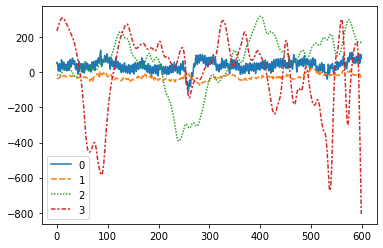

In [24]:
sns.lineplot(data=j3_samples[0].T)

<AxesSubplot:>

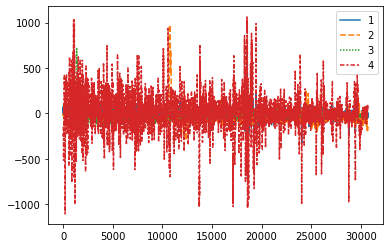

In [25]:
sns.lineplot(data=pd.read_pickle("Jack_Mandarin_3")[[1, 2, 3, 4]])

<AxesSubplot:>

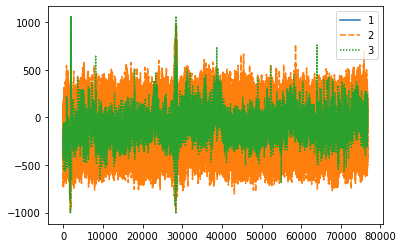

In [55]:
sns.lineplot(data=pd.read_pickle("Rena_Korean")[[1, 2, 3]])

<AxesSubplot:>

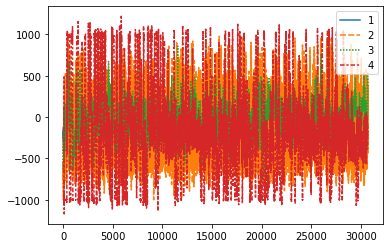

In [54]:
sns.lineplot(data=pd.read_pickle("Rena_Korean_2")[[1, 2, 3, 4]])


In [27]:
tf.math.confusion_matrix(tf.argmax(rena_labels, axis=1), tf.argmax(model_rev.predict(rena_samples), axis=1))


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[798, 202],
       [ 57, 943]], dtype=int32)>